# Transfer learning: training shallow classifiers on embedding models outputs

If you want to adapt BirdNET, Perch, HawkEars, or another foundation model to a new set of classes or a new domain, you'll be doing what machine learning experts call transfer learning. This tutorial demonstrates tranfer learning for PyToch models, but you can do the same with TensorFlow models such as BirdNET and Perch - examples are in a separate notebook `training_birdnet_and_perch.ipynb` since you might need to set your python environment up differently (by installing tensorflow and tensorflow-hub packages).

This notebook shows examples of how to train simple one-layer or multi-layer fully-connected neural networks (aka multi-layer perceptron networks, MLPs) on embedding (aka features) generated by a pre-trained deep learning model. This workflow is called transfer learning because the learned feature extraction of the embedding model is transfered to a new domain. Ghani et al. [1] demonstrated that gobal bird classification models can act as feature extractors that can be used to train shallow classifiers on novel tasks and domains, even when few training samples are available.

Training a shallow classifier on embeddings, rather than training or fine-tuning an entire deep learning model, has three advantages: (1) classifiers can be developed with just a handful of training examples; (2) models fit very quickly, enabling an iterative human-in-the-loop workflow for active learning; (3) any model that generates embeddings can be used as the feature extractor; in particular, compiled models without open-source weights (e.g. BirdNET [2]) can be used as the embedding model.

Users can develop flexible and customizable transfer-learning workflow by generating embeddings then using PyTorch or sklearn directly. This notebook demonstrates both (1) high-level functions and classes in OpenSoundscape that simplify the code needed to perform transfer learning; and (2) examples demonstrating the embedding and model fitting steps explicitly line-by-line.

> Note: to use models from the model zoo, install the bioacoustics_model_zoo as a package in your python environment:

`pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo`

[1] Ghani, B., T. Denton, S. Kahl, H. Klinck, T. Denton, S. Kahl, and H. Klinck. 2023. Global birdsong embeddings enable superior transfer learning for bioacoustic classification. Scientific Reports 13:22876.

[2] Kahl, Stefan, et al. "BirdNET: A deep learning solution for avian diversity monitoring." Ecological Informatics 61 (2021): 101236.


## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [3]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install opensoundscape==0.12.0 ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0
  %pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo
  num_workers=0
else:
  # choose cpu parallelization count
  num_workers=4

## Setup

### Import needed packages

In [4]:
#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


### Set random seeds

Set manual seeds for Pytorch and Python. These essentially "fix" the results of any stochastic steps in model training, ensuring that training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Download and prepare training data


#### Download example files
Download a set of aquatic soundscape recordings with annotations of _Rana sierrae_ vocalizations

Option 1: run the cell below

- if you get a 403 error, DataDryad suspects you are a bot. Use Option 2. 

Option 2:

- Download and unzip the `rana_sierrae_2022.zip` folder containing audio and annotations from this [public Dryad dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.9s4mw6mn3#readme)
- Move the unzipped `rana_sierrae_2022` folder into the current folder

In [6]:
# # Note: the "!" preceding each line below allows us to run bash commands in a Jupyter notebook
# # If you are not running this code in a notebook, input these commands into your terminal instead
# !wget -O rana_sierrae_2022.zip https://datadryad.org/stash/downloads/file_stream/2722802;
# !unzip rana_sierrae_2022;

#### Prepare audio data
See the train_cnn.ipynb tutorial for step-by-step walkthrough of this process, or just run the cells below to prepare a trainig set.

In [7]:
# Set the current directory to where the folder `rana_sierrae_2022` is located:
dataset_path = Path("./rana_sierrae_2022/")

# let's generate clip labels of 5s duration (to match HawkEars) using the raven annotations
# and some utility functions from opensoundscape
from opensoundscape.annotations import BoxedAnnotations

audio_and_raven_files = pd.read_csv(f"{dataset_path}/audio_and_raven_files.csv")
# update the paths to where we have the audio and raven files stored
audio_and_raven_files["audio"] = audio_and_raven_files["audio"].apply(
    lambda x: f"{dataset_path}/{x}"
)
audio_and_raven_files["raven"] = audio_and_raven_files["raven"].apply(
    lambda x: f"{dataset_path}/{x}"
)

annotations = BoxedAnnotations.from_raven_files(
    raven_files=audio_and_raven_files["raven"],
    audio_files=audio_and_raven_files["audio"],
    annotation_column="annotation",
)
# generate labels for 5s clips, including any labels that overlap by at least 0.2 seconds
labels = annotations.clip_labels(clip_duration=5, min_label_overlap=0.2)

/Users/SML161/opensoundscape/opensoundscape/annotations.py:333: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_annotations_df = pd.concat(all_file_dfs).reset_index(drop=True)


#### Inspect labels

Count number of each annotation type: 

Note that the 'X' label is for when the annotator was uncertain about the identity of a call. Labels A-E denote distinct call types.

In [8]:
labels.sum()

A    512
E    128
D     62
B     24
C     74
X    118
dtype: int64

#### split into training and validation data
We'll just focus on class 'A', the call type with the most annotations. We'll randomly split the clips into training and validation data, acknowledging that this approach does not test the ability of the model to generalize. Since the samples in the training and validation sets could be adjascent 2-second audio clips, good performance could simply mean the model has memorized the training samples, and the validation set has very similar samples. 

In [9]:
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[["A"]])

## Train shallow classifiers on embedding model outputs

We'll train our classifiers on a small annotated dataset with HawkEars, Perch, and BirdNET as feature extractors.

In [29]:
import bioacoustics_model_zoo as bmz

hawk = bmz.HawkEars()

File hgnet1.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet1.ckpt...
File hgnet2.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet2.ckpt...
File hgnet3.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet3.ckpt...
File hgnet4.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet4.ckpt...
File hgnet5.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet5.ckpt...


/Users/SML161/opensoundscape/opensoundscape/preprocess/preprocessors.py:512: DeprecationWarning: sample_shape argument is deprecated. Please use height, width, channels arguments instead. 
                The current behavior is to override height, width, channels with sample_shape 
                when sample_shape is not None.
                
  warnings.warn(
/Users/SML161/opensoundscape/opensoundscape/ml/cnn.py:599: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constru

Create a shallow classifier that we'll train with embeddings as inputs. The input size needs to match the size of the embeddings produced by our embedding model. HawkEars embeddings are vectors of length 2048. 

In [30]:
clf = MLPClassifier(
    input_size=2048, output_size=labels_train.shape[1], hidden_layer_sizes=()
)

We can run a single function that will embed the training and validation samples, then train the classifier.

This will take a minute or two, since all of the samples need to be embedded with HawkEars.

In [ ]:
from opensoundscape import CNN

m = CNN("resnet18", [0], 2)

In [32]:
hawk.embed?
#(labels_train)

Signature:
hawk.embed(
    samples,
    target_layer=None,
    progress_bar=True,
    return_preds=False,
    avgpool=True,
    return_dfs=True,
    audio_root=None,
    **dataloader_kwargs,
)
Docstring:
Generate embeddings (intermediate layer outputs) for audio files/clips

Note: to capture embeddings on multiple layers, use self.__call__ with intermediate_layers
argument directly. This wrapper only allows one target_layer.

Note: Output can be n-dimensional array (return_dfs=False) or pd.DataFrame with multi-index
like .predict() (return_dfs=True). If avgpool=False, return_dfs is forced to False since we
can't create a DataFrame with >2 dimensions.

Args:
    samples: same as CNN.predict(): list of file paths, OR pd.DataFrame with index
        containing audio file paths, OR a pd.DataFrame with multi-index (file, start_time,
        end_time)
    target_layers: layers from self.model._modules to
        extract outputs from - if None, attempts to use self.model.embedding_layer as
  

In [33]:
emb_train, label_train, emb_val, label_val = fit_classifier_on_embeddings(
    embedding_model=hawk,
    classifier_model=clf,
    train_df=labels_train,
    validation_df=labels_val,
    steps=1000,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
)

Embedding the training samples without augmentation


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpc_a47aje'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmp71w8_vl5'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpp0cl22y_'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpfe56hzio'>
  _warnings.warn(warn_message, ResourceWarning)


Embedding the validation samples


  0%|          | 0/3 [00:00<?, ?it/s]

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpd32bi6rm'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmp23kcm49y'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmp8lzql5hp'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpjrvrujzx'>
  _warnings.warn(warn_message, ResourceWarning)


Fitting the classifier
Epoch 100/1000, Loss: 0.550883948802948, Val Loss: 0.5516770482063293
val AU ROC: 0.804
val MAP: 0.768
Epoch 200/1000, Loss: 0.5038763880729675, Val Loss: 0.5115477442741394
val AU ROC: 0.810
val MAP: 0.775


/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = to

Epoch 300/1000, Loss: 0.48154526948928833, Val Loss: 0.49445003271102905
val AU ROC: 0.815
val MAP: 0.779
Epoch 400/1000, Loss: 0.4678399860858917, Val Loss: 0.48483508825302124
val AU ROC: 0.818
val MAP: 0.783
Epoch 500/1000, Loss: 0.4578171670436859, Val Loss: 0.47837916016578674
val AU ROC: 0.822
val MAP: 0.787
Epoch 600/1000, Loss: 0.449672132730484, Val Loss: 0.47367215156555176
val AU ROC: 0.824
val MAP: 0.790
Epoch 700/1000, Loss: 0.44261693954467773, Val Loss: 0.4701281487941742
val AU ROC: 0.825
val MAP: 0.791
Epoch 800/1000, Loss: 0.43625712394714355, Val Loss: 0.46743637323379517
val AU ROC: 0.826
val MAP: 0.793
Epoch 900/1000, Loss: 0.43037843704223633, Val Loss: 0.4654019773006439
val AU ROC: 0.826
val MAP: 0.795
Epoch 1000/1000, Loss: 0.42485761642456055, Val Loss: 0.4638913869857788
val AU ROC: 0.827
val MAP: 0.797
Training complete


let's evaluate our shallow classifier on the test set:

In [34]:
# predict classes with the shallow classifier starting from the embeddings
preds = clf(emb_val.to(torch.device("cpu"))).detach().numpy()

# evaluate with threshold agnostic metrics: MAP and ROC AUC
print(
    f"average precision score: {average_precision_score(label_val,preds,average=None)}"
)
print(f"area under ROC: {roc_auc_score(label_val,preds,average=None)}")

average precision score: 0.7966096322008143
area under ROC: 0.8268707482993197


to visualize the performance, let's plot histograms of classifier logit scores for positive and negative samples

it shows that precision is good for scores above >0 (few negatives get high scores), but recall is only moderate (many positive samples get low scores)

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


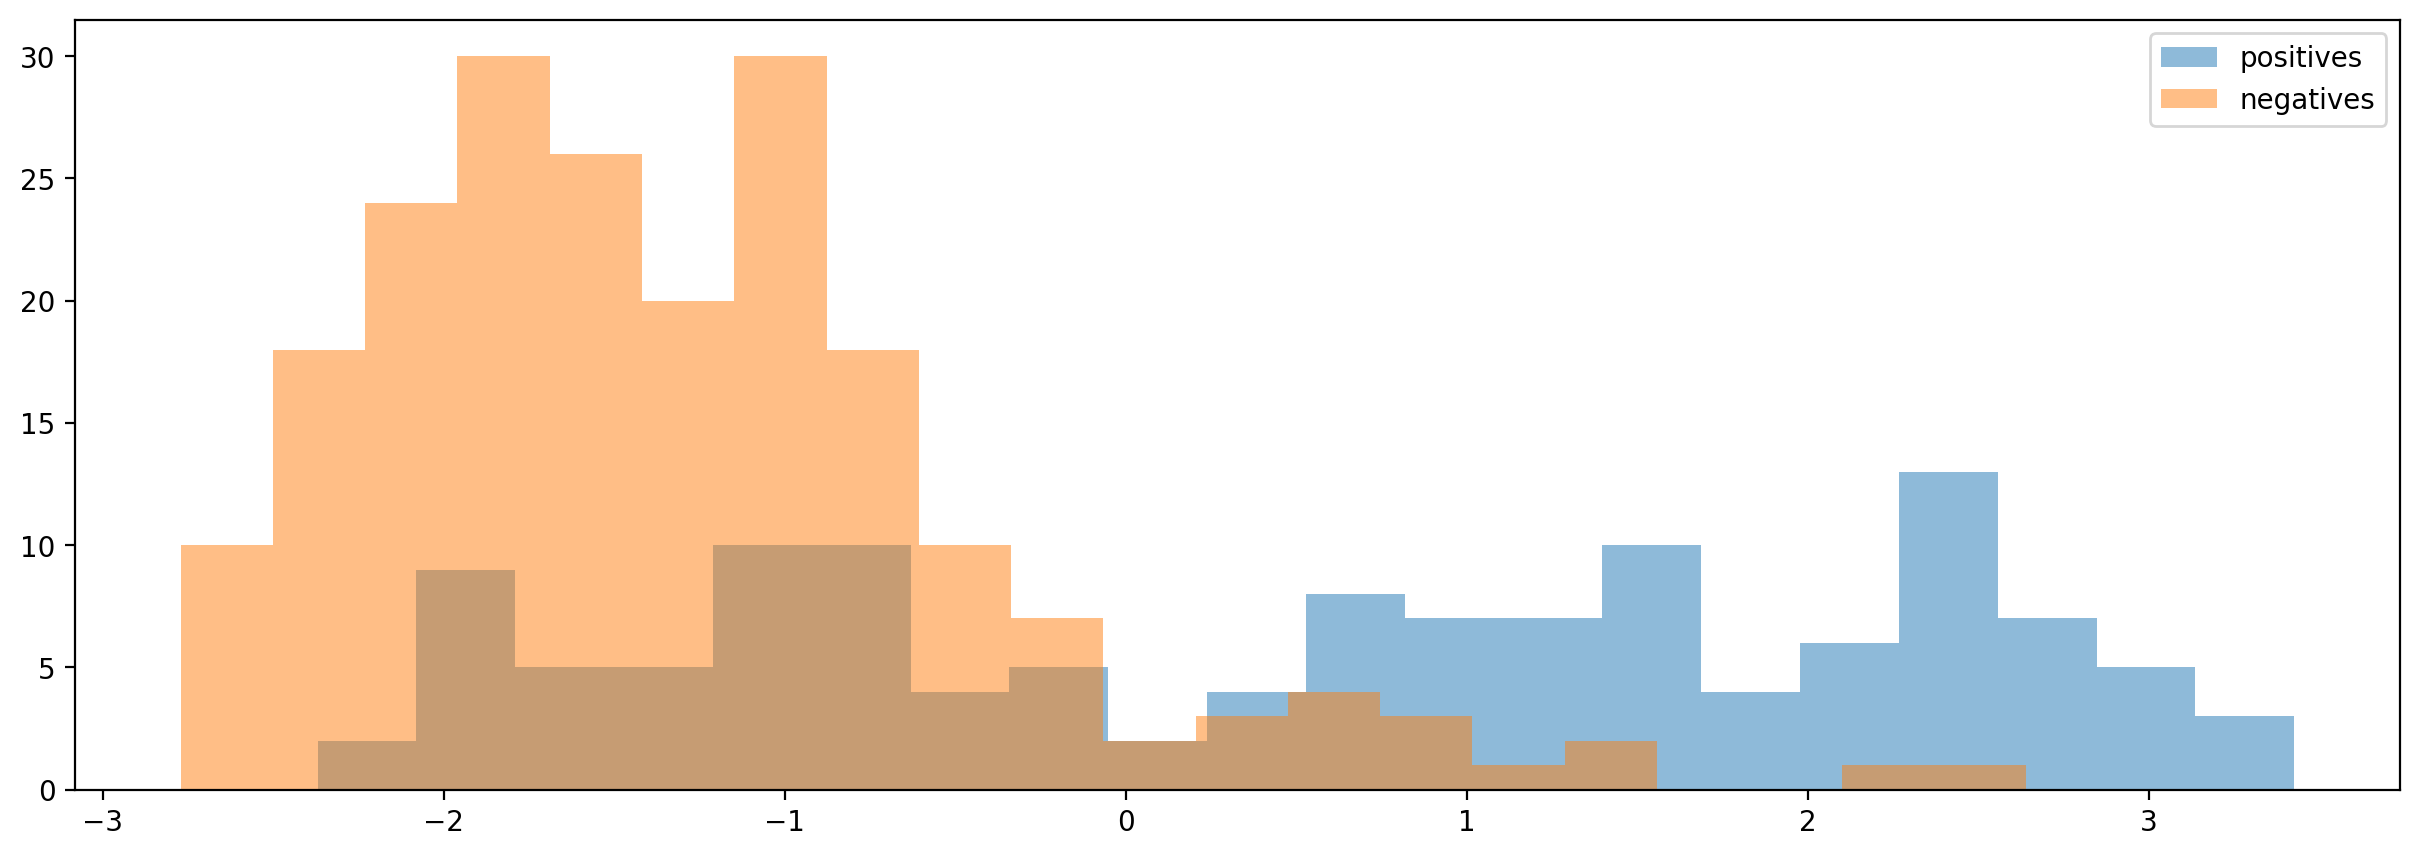

In [35]:
plt.hist(preds[label_val == 1], bins=20, alpha=0.5, label="positives")
plt.hist(preds[label_val == 0], bins=20, alpha=0.5, label="negatives")
plt.legend()

Alternatively, we can embed the training and validation sets first, then train as many different variants as we want.

(note that the `fit_classifier_on_embeddings` returns the embeddings on the training and validation set, so if you've already run that function you don't need to re-generate the embeddings)

Generally, embedding may take a while for large datasets, but training the shallow classifier will be very fast because the network is small and there is no preprocessing or data loading. 

For example, here we compare fitting classifiers with one or two hidden layers on the same data:

In [36]:
# uncomment the lines below to generate training and validation set embeddings, if you don't have them from the previous cells
# emb_train = hawk.embed(labels_train, return_dfs=False, batch_size=128, num_workers=num_workers)
# emb_val = hawk.embed(labels_val, return_dfs=False, batch_size=128, num_workers=num_workers)

In [37]:
# define classifier with one hidden layer, and fit
classifier_model_1 = MLPClassifier(2048, 1, hidden_layer_sizes=(100,))
classifier_model_1.fit(
    emb_train, labels_train.values, emb_val, labels_val.values, steps=1000
)

# define classifier with two hidden layers, and fit
classifier_model_2 = MLPClassifier(2048, 1, hidden_layer_sizes=(100, 100))
classifier_model_2.fit(
    emb_train, labels_train.values, emb_val, labels_val.values, steps=1000
)

/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.42801418900489807, Val Loss: 0.46339496970176697
val AU ROC: 0.827
val MAP: 0.796
Epoch 200/1000, Loss: 0.3507393002510071, Val Loss: 0.4778691232204437
val AU ROC: 0.808
val MAP: 0.787
Epoch 300/1000, Loss: 0.27483296394348145, Val Loss: 0.5363744497299194
val AU ROC: 0.787
val MAP: 0.774
Epoch 400/1000, Loss: 0.2075444459915161, Val Loss: 0.6220154166221619
val AU ROC: 0.769
val MAP: 0.760
Epoch 500/1000, Loss: 0.15723513066768646, Val Loss: 0.7255039811134338
val AU ROC: 0.758
val MAP: 0.749
Epoch 600/1000, Loss: 0.12125258147716522, Val Loss: 0.8389410972595215
val AU ROC: 0.753
val MAP: 0.743
Epoch 700/1000, Loss: 0.09492244571447372, Val Loss: 0.9559184312820435
val AU ROC: 0.749
val MAP: 0.738
Epoch 800/1000, Loss: 0.07483015209436417, Val Loss: 1.073399305343628
val AU ROC: 0.745
val MAP: 0.733
Epoch 900/1000, Loss: 0.05932421237230301, Val Loss: 1.193526268005371
val AU ROC: 0.740
val MAP: 0.726
Epoch 1000/1000, Loss: 0.047229062765836716, Val Loss: 1.3

/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.352482408285141, Val Loss: 0.48463407158851624
val AU ROC: 0.805
val MAP: 0.784
Epoch 200/1000, Loss: 0.18686117231845856, Val Loss: 0.7288596630096436
val AU ROC: 0.758
val MAP: 0.745
Epoch 300/1000, Loss: 0.09721919149160385, Val Loss: 1.0628374814987183
val AU ROC: 0.739
val MAP: 0.724
Epoch 400/1000, Loss: 0.0494694784283638, Val Loss: 1.4031246900558472
val AU ROC: 0.732
val MAP: 0.712
Epoch 500/1000, Loss: 0.02575032413005829, Val Loss: 1.736872673034668
val AU ROC: 0.728
val MAP: 0.705
Epoch 600/1000, Loss: 0.013688751496374607, Val Loss: 2.0353024005889893
val AU ROC: 0.727
val MAP: 0.702
Epoch 700/1000, Loss: 0.007962996140122414, Val Loss: 2.2820372581481934
val AU ROC: 0.725
val MAP: 0.700
Epoch 800/1000, Loss: 0.0050779590383172035, Val Loss: 2.4839770793914795
val AU ROC: 0.722
val MAP: 0.696
Epoch 900/1000, Loss: 0.003480414394289255, Val Loss: 2.651313066482544
val AU ROC: 0.722
val MAP: 0.695
Epoch 1000/1000, Loss: 0.002518742810934782, Val Loss:

In [38]:
# evaluate
preds = classifier_model_1(emb_val)
print(
    f"classifier_model_1 area under ROC: {roc_auc_score(labels_val.values,preds.detach().numpy(),average=None)}"
)

preds = classifier_model_2(emb_val)
print(
    f"classifier_model_2 area under ROC: {roc_auc_score(labels_val.values,preds.detach().numpy(),average=None)}"
)

classifier_model_1 area under ROC: 0.7372260015117157
classifier_model_2 area under ROC: 0.7212396069538927


### train on variants of the embeddings generated with audio-space augmentations

The `fit_classifier_on_embeddings` function supports generating variants of training samples with augmentation via the parameter `n_augmentation_variants`. The default 0 does not perform augentation. Specifying a positive integer tells the function to generate each sample n times using stochastic augmentation. The specific augmentations performed are defined by the embedding model's `.preprocessor`. 

We can also generate the augmented samples directly using `opensoundscape.ml.shallow_classifier.augmented_embed`, similarly to how we generated embeddings above then trained various models on them. Note that preprocessing and sample loading is repeated for each iteration of augmented data creation, so augmented_embed will take `n_augmentation_variants` times longer than embedding without augmentation. The benefit is that augmenting the audio samples before embedding tends to improve model performance more than simply augmenting the embeddings themselves (e.g. by adding random noise). 

For the sake of speed, we demonstrate augmented embedding here on only a subset of the training data

In [39]:
from opensoundscape.ml.shallow_classifier import augmented_embed

train_emb_aug, train_label_aug = augmented_embed(
    hawk,
    labels_train.sample(512),
    batch_size=128,
    num_workers=num_workers,
    n_augmentation_variants=4,
)

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpf98bhsiu'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmp2cglssz6'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmp6sxy356b'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpa5lgjd6h'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/op

we embed the validation set as normal, without any augmentation

In [40]:
# uncomment and run if you don't already have emb_val from previous steps
# emb_val = hawk.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

fitting the classifier on the augmented variants' embeddings looks the same as before:

In [41]:
classifier_model = MLPClassifier(2048, 1, hidden_layer_sizes=())
quick_fit(
    classifier_model,
    train_emb_aug,
    train_label_aug,
    emb_val,
    labels_val.values,
    steps=1000,
)

/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = to

Epoch 100/1000, Loss: 0.6358025074005127, Val Loss: 0.5764970183372498
val AU ROC: 0.810
val MAP: 0.777
Epoch 200/1000, Loss: 0.6124716997146606, Val Loss: 0.532778263092041
val AU ROC: 0.815
val MAP: 0.784
Epoch 300/1000, Loss: 0.5981889367103577, Val Loss: 0.5130545496940613
val AU ROC: 0.818
val MAP: 0.789
Epoch 400/1000, Loss: 0.5879126191139221, Val Loss: 0.5014684796333313
val AU ROC: 0.819
val MAP: 0.791
Epoch 500/1000, Loss: 0.5796589851379395, Val Loss: 0.4930368959903717
val AU ROC: 0.822
val MAP: 0.792
Epoch 600/1000, Loss: 0.5726227760314941, Val Loss: 0.4864462912082672
val AU ROC: 0.824
val MAP: 0.795
Epoch 700/1000, Loss: 0.5664262175559998, Val Loss: 0.4813237488269806
val AU ROC: 0.826
val MAP: 0.796
Epoch 800/1000, Loss: 0.560860276222229, Val Loss: 0.4774751663208008
val AU ROC: 0.827
val MAP: 0.797
Epoch 900/1000, Loss: 0.5557926893234253, Val Loss: 0.4747283160686493
val AU ROC: 0.828
val MAP: 0.797
Epoch 1000/1000, Loss: 0.5511319041252136, Val Loss: 0.47291892766

evaluate:

In [42]:
preds = classifier_model(torch.tensor(emb_val).to(torch.device("cpu")))
roc_auc_score(labels_val.values, preds.detach().numpy(), average=None)

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_59299/1566684614.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = classifier_model(torch.tensor(emb_val).to(torch.device("cpu")))


0.8280423280423281

## Fit SKLearn Classifiers on embeddings
scikit-learn provides various classification algorithms as alternatives to the MLPClassifier implemented in OpenSoundscape via PyTorch. It's straightforward to fit any sklearn model on embeddings: 

In [43]:
from sklearn.ensemble import RandomForestClassifier

# initialize a random forest class from sklearn
rf = RandomForestClassifier()

# fit the model on training set embeddings
rf.fit(emb_train, labels_train.values[:, 0])

# evaluate on the validation set
preds = rf.predict(emb_val)
roc_auc_score(labels_val.values, preds, average=None)

0.7523809523809524

here's another example with K nearest neighbors classification:

In [44]:
from sklearn.neighbors import KNeighborsClassifier

# initialize classifier
knc = KNeighborsClassifier()

# fit on training set embeddings
knc.fit(emb_train, labels_train.values[:, 0])

# evaluate on validation set
preds = knc.predict(emb_val)
roc_auc_score(labels_val.values, preds, average=None)

0.7396825396825397

## Fit a classifier that is a layer in an exisisting OpenSoundscape model

If you have a fully connected layer at the end of an existing OpenSoundscape model, training that layer works similarly to training a separate MLPClassifier object. We can use the `quick_fit` function to train the layer on pre-generated embeddings (output of previous network layer) to avoid the slow-down associated with preprocessing samples for every training step. 

For example, let's load up a CNN trained in OpenSoundscape from the model zoo. This CNN was trained to detect the A and B call types of Rana Sierrae vocalizations. It has a resnet18 architecture that ends with a fully connected classifier layer. 

In [46]:
import bioacoustics_model_zoo as bmz

rana_sierrae_cnn = bmz.RanaSierraeCNN()
train_emb = rana_sierrae_cnn.embed(
    labels_train, return_dfs=False, batch_size=128, num_workers=num_workers
)
val_emb = rana_sierrae_cnn.embed(
    labels_val, return_dfs=False, batch_size=128, num_workers=num_workers
)

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmp40f_rphu'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpee3b4bca'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmp1is9rxeg'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpbi4dketx'>
  _warnings.warn(warn_message, ResourceWarning)


  0%|          | 0/3 [00:00<?, ?it/s]

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpk6raqggv'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpymaz7q9i'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpa_fkzs6m'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpug9a38y7'>
  _warnings.warn(warn_message, ResourceWarning)


In [47]:
# modify the last layer of the CNN to have a single output for the class 'A'
rana_sierrae_cnn.change_classes(["A"])  # replace fc layer with 1-output layer

# fit the fc layer within the opso CNN by passing the layer to the `quick_fit` function
quick_fit(
    rana_sierrae_cnn.network.fc,
    train_emb,
    labels_train.values,
    val_emb,
    labels_val.values,
    steps=1000,
)

Epoch 100/1000, Loss: 0.4183506369590759, Val Loss: 0.47312527894973755
val AU ROC: 0.845
val MAP: 0.775
Epoch 200/1000, Loss: 0.3923477232456207, Val Loss: 0.4774077236652374
val AU ROC: 0.846
val MAP: 0.779
Epoch 300/1000, Loss: 0.3722660541534424, Val Loss: 0.4802170395851135
val AU ROC: 0.844
val MAP: 0.777
Epoch 400/1000, Loss: 0.3556406795978546, Val Loss: 0.4827151894569397
val AU ROC: 0.842
val MAP: 0.778
Epoch 500/1000, Loss: 0.3414366841316223, Val Loss: 0.4857030510902405
val AU ROC: 0.839
val MAP: 0.777
Epoch 600/1000, Loss: 0.3290245831012726, Val Loss: 0.4892197549343109
val AU ROC: 0.838
val MAP: 0.778
Epoch 700/1000, Loss: 0.3179768919944763, Val Loss: 0.49323374032974243
val AU ROC: 0.836
val MAP: 0.779
Epoch 800/1000, Loss: 0.3079927861690521, Val Loss: 0.4977739453315735
val AU ROC: 0.834
val MAP: 0.780
Epoch 900/1000, Loss: 0.2988574802875519, Val Loss: 0.5028876066207886
val AU ROC: 0.833
val MAP: 0.780
Epoch 1000/1000, Loss: 0.29041510820388794, Val Loss: 0.508602

In [48]:
# evaluate:

# can use regular prediction since we modified the in-network classifier
# but this will be slower than just running the fc layer on the embeddings, since it requires
# preprocessing and running the entire CNN architecture forward pass
preds = rana_sierrae_cnn.predict(labels_val, batch_size=128)
roc_auc_score(labels_val.values, preds, average=None)

  0%|          | 0/3 [00:00<?, ?it/s]

0.8314058956916098

We could equivalently get the prediciton by passing the embeddings through the trained fc layer. The outputs should be numerically similar to prediction starting from the audio clips:


In [49]:
preds2 = (
    rana_sierrae_cnn.network.fc(torch.tensor(val_emb).to(torch.device("mps")))
    .detach()
    .cpu()
    .numpy()
)
np.max(np.abs((preds.values - preds2)))

0.0

We could also replace the cnn's `.fc` layer with an MLPClassifier object, if we want the classifier to be more than one fully-connected layer. 